In [ ]:
import flopy


In [381]:
steady

array([False, False, False, False, False, False, False, False, False,
       False, False,  True])

In [487]:

# Define model workspace
model_ws = "./modflow_model_2"

# Create a MODFLOW model instance
model = flopy.modflow.Modflow(modelname="example_model", model_ws=model_ws, exe_name="mf2005")

# Define model dimensions
nlay = 50
nrow = 190
ncol = 220
delr = 12.0  # Cell width along rows (extend 2200 / 220)
delc = 12.0  # Cell width along columns (extend 1900 / 190)

# Define top elevation
top_elev = 190.0

# Define layer thickness (uniform thickness)
layer_thickness = 25.0 / nlay

perlen = 30
nper = 5
nstp = np.repeat(1,nper)
steady = np.append(np.repeat(False,nper-1),np.array([True]))

# Create DIS package
dis = flopy.modflow.ModflowDis(model, nlay=nlay, nrow=nrow, ncol=ncol, delr=delr, delc=delc,top=top_elev, 
                               botm=[top_elev - (i * layer_thickness) for i in range(1, nlay + 1)],
                               nper = nper,
                               perlen = perlen,
                               nstp = nstp,
                               steady = steady)



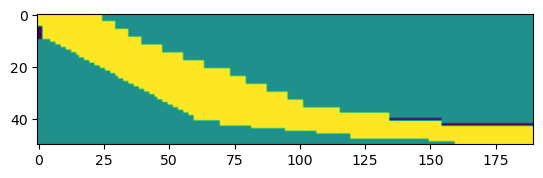

In [488]:



# Define ibound and initial conditions
ibound = np.ones((nlay, nrow, ncol), dtype=int)

# Set constant head boundary conditions for the first and last rows

ibound[5:10, 0:2, :] = -1  # Constant head for the first row
#ibound[:, -1, :] = -1  # Constant head for the last row




# Change the values in the top left corner to 1s
ibound[:3, 25:,:] = 0
ibound[3:6, 30:,:] = 0
ibound[6:9, 35:,:] = 0
ibound[9:12, 40:,:] = 0
ibound[12:15, 48:,:] = 0
ibound[15:18, 56:,:] = 0
ibound[18:21, 64:,:] = 0
ibound[21:24, 74:,:] = 0
ibound[24:27, 80:,:] = 0
ibound[27:30, 88:,:] = 0
ibound[30:33, 96:,:] = 0
ibound[33:36, 102:,:] = 0
ibound[36:38, 116:,:] = 0
ibound[38:40, 135:,:] = 0
ibound[40:42, 155:,:] = 0

ibound[40, 135:155,:] = -1
ibound[42, 155:,:] = -1





rows  = [160]+[150] + [120]  + list(np.linspace(120,70,5).astype(int)) + list(np.linspace(70,60,2).astype(int)) + list(np.linspace(60,0,33).astype(int))
for layer in range(40):
    row = rows[layer]
    ibound[49-layer,:row,:]= 0


#ibound[45:-1, 180:,:] = 0


plt.imshow(ibound[:,:,2])



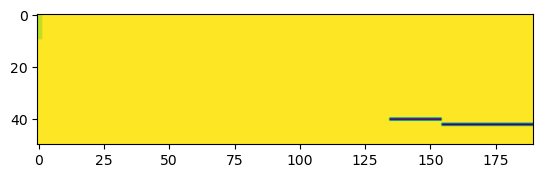

In [489]:
# Define initial head conditions
initial_head = np.full((nlay, nrow, ncol),190, dtype=float)
initial_head[:10, 0:2, :] = 188  # Initial head for the first row
#initial_head[:, -1, :] = 178.0  # Initial head for the last row
initial_head[40, 135:155,:] = 170
initial_head[42, 155:,:] = 170

plt.imshow(initial_head[:,:,3])
#plt.colorbar()

In [483]:

# Create BAS package
bas = flopy.modflow.ModflowBas(model, ibound=ibound, strt=initial_head)

# Define hydraulic properties
horizontal_k = 6.9  # Horizontal hydraulic conductivity (m/day)
vertical_k = 0.1   # Vertical hydraulic conductivity (m/day)
porosity = 0.25     # Porosity

# Create LPF package (Layer Property Flow package)
lpf = flopy.modflow.ModflowLpf(model, hk=horizontal_k, vka=vertical_k, laytyp=1, ipakcb=53,ss=0.0002,sy=0.33)



pcg = flopy.modflow.ModflowPcg(model, hclose=1e-3)


# Create a steady-state MODFLOW model
# You can add additional packages and settings as needed for your specific problem


# OC - Output Control Option
oc = flopy.modflow.ModflowOc(
    model,
    stress_period_data= None,
    compact=True,
)

# Write MODFLOW input files
model.write_input()

In [484]:


# Run the MODFLOW model
model.run_model()


FloPy is using the following executable to run the model: C:\Users\swan47\AppData\Local\flopy\bin\mf2005.EXE

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: example_model.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/09/07  1:24:55

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/09/07  1:25:35
 Elapsed run time: 39.377 Seconds

  Normal termination of simulation


(True, [])

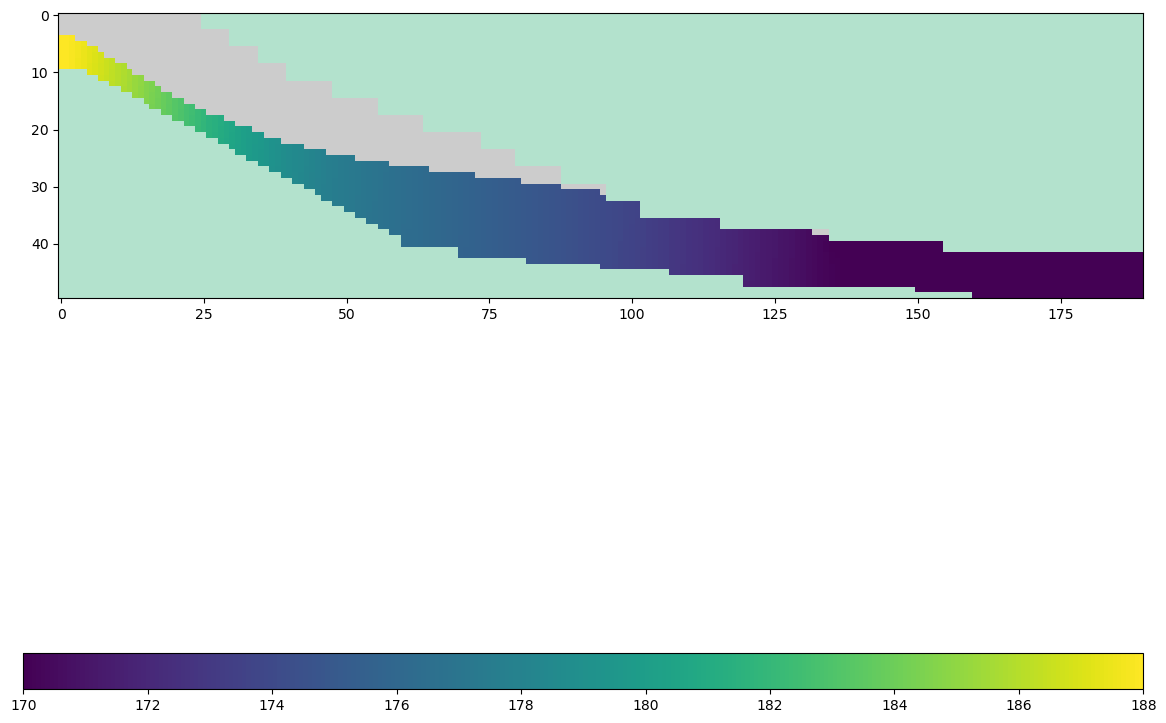

In [486]:

budobj = bf.HeadFile(model_ws + '/example_model.hds')
times = budobj.get_times()
head = budobj.get_data(totim=times[-1])
# Assuming 'head', 'ibound' are defined somewhere in your code

arr = head[:, :, 10].copy()
arr[arr < 0] = np.nan

topo = ibound[:, :, 0].copy()
topo[topo == -1] = 1



# Create a 2x1 grid of subplots
fig,ax1 = plt.subplots(figsize=(14,12))
#fig.figure()

# Plot 'topo' in the first subplot
ax1.imshow(topo, cmap='Pastel2')

# Plot 'arr' in the second subplot
im = ax1.imshow(arr)

# Create a colorbar at the bottom
cax = fig.add_axes([0.1, 0.05, 0.8, 0.03])  # [left, bottom, width, height]
cbar = plt.colorbar(im, cax=cax, orientation='horizontal')

# Show the plots
plt.show()

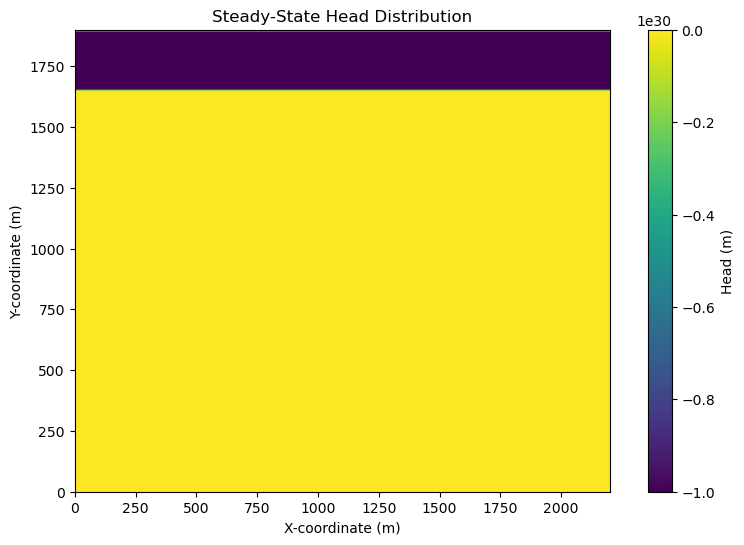

In [137]:
# Import necessary libraries for plotting
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

# Load the binary output file
budobj = bf.HeadFile(model_ws + '/example_model.hds')
head = budobj.get_data()

# Plot the results
plt.figure(figsize=(10, 6))
plt.imshow(head[0, :, :], cmap='viridis', extent=(0, ncol * delr, 0, nrow * delc))
plt.colorbar(label='Head (m)')
plt.xlabel('X-coordinate (m)')
plt.ylabel('Y-coordinate (m)')
plt.title('Steady-State Head Distribution')
plt.show()
